# Applied Data Science by IBM
## Capstone project

### Introduction

Moscow and New York are two big cities that "never sleep". Both cities have milions of people, have lots of things to do and places to go to. At the same time, being found in 1147, Moscow has longer history, and New York city is highly enriched with culture brought by immigrants of various nationalities.

Imagine, for example, that we want to sell appartments in New York to Russian speaking customers. Where will they feel like being home?
Can we use data science tools to determine if there are similar districts in Moscow and New York?

In this project, we are going to explore, segment and compare the neighborhoods of Moscow and New York.
To do this, we are going to make a table of districts for each city, explore venues in each district using FoursquareAPI, then perform clustering using Scikit-learn library and visualize the clusters using Folium

In [80]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Install beautifulsoup
#!pip install beautifulsoup4
from bs4 import BeautifulSoup

#Import libraries for Foursquare API
from urllib.request import urlopen
import requests 
from pandas.io.json import json_normalize
import json

#Install geocode for getting coordinates
#!pip install geopy
from geopy.geocoders import Nominatim

#Install sci kit learn for machine learning
from sklearn.cluster import KMeans

#!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 904 kB 15.0 MB/s eta 0:00:01


### Data

For New York we are going to use data from the Applied Data Science - Capstone project course by IBM at [Coursera](https://www.coursera.org/learn/applied-data-science-capstone/home/welcome). This data contains names and geolocation coordinates for neighborhoods of New York city, including Manhattan, Brooklyn, Queens, Bronx and Staten Island boroughs. For Moscow we don't have such data readily available, so we will use [Wikipedia](https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow) page to find all districts of Moscow, then will use geopy library to find geolocation for each district.

To explore venues, we will use [Foursquare API](https://developer.foursquare.com/), a tool for accessing data about venues (restaurants, stores, museums, parks etc), including location, venue type, menu (if any), pictures, reviews and so on. In this project, we will need to find out what venue types are most represented in each district

In [2]:
#get Moscow neighborhood data on Wikipedia using BeautifulSoup
url = 'https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow'
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")

In [3]:
#get a table containing all districts of Moscow
table_content = []
for table in soup.findAll('table'):
    for row in table.findAll('td'):
        cell = {}
        try:
            #print(row.dl.dd.a)
            cell['District'] = row.dl.dd.a.text
            table_content.append(cell)
        except:
            pass
        
        
print(len(table_content))

#At the moment, Moscow has 146 districts

146


In [4]:
#Create dataframe
moscow_df = pd.DataFrame(table_content)
moscow_df.head(10)

,District
0,Arbat
1,Basmanny
2,Khamovniki
3,Krasnoselsky
4,Meshchansky
5,Presnensky
6,Tagansky
7,Tverskoy
8,Yakimanka
9,Zamoskvorechye


Now that we have a table of all districts of Moscow, we are going to add coordinates to each district using geopy

In [5]:
#Get gecoordinates
geolocator = Nominatim(user_agent="MoscowDistricts")

for cell in zip(moscow_df['District']):
    district = cell[0]
    #print(district)
    location = geolocator.geocode(district + " , Moscow")
    #print(postal_code, location.latitude, location.longitude)
    try:
        moscow_df.loc[moscow_df['District'] == district, "Latitude"] = location.latitude
        moscow_df.loc[moscow_df['District'] == district, "Longitude"] = location.longitude
    except:
        print("Problem with district: " + district)

print(moscow_df.shape)
moscow_df.head(10)

Problem with district: Severnoye Tushino
Problem with district: Vnukovskoye Settlement
Problem with district: Voskresenskoye Settlement
Problem with district: Desyonovskoye Settlement
Problem with district: Marushkinskoye Settlement
Problem with district: Mosrentgen Settlement
Problem with district: Ryazanovskoye Settlement
Problem with district: Sosenskoye Settlement
Problem with district: Filimonkovskoye Settlement
Problem with district: Voronovskoye Settlement
Problem with district: Kiyevsky Settlement
Problem with district: Klenovskoye Settlement
Problem with district: Krasnopakhorskoye Settlement
Problem with district: Mikhaylovo-Yartsevskoye Settlement
Problem with district: Novofyodorovskoye Settlement
Problem with district: Pervomayskoye Settlement
Problem with district: Rogovskoye Settlement
Problem with district: Troitsky Settlement
Problem with district: Shchapovskoye Settlement
(146, 3)


,District,Latitude,Longitude
0,Arbat,55.751199,37.589872
1,Basmanny,55.757774,37.662184
2,Khamovniki,55.702297,37.531798
3,Krasnoselsky,55.774248,37.659914
4,Meshchansky,55.763013,37.622559
5,Presnensky,55.756276,37.605422
6,Tagansky,55.741572,37.667063
7,Tverskoy,55.762539,37.608913
8,Yakimanka,55.738374,37.616913
9,Zamoskvorechye,55.729095,37.641031


In [6]:
#clean up table
moscow_df = moscow_df.dropna()
moscow_df.shape

(127, 3)

Now we get New York data as we did in the week 3 of the IBM course

In [7]:
#Download New York data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [8]:
#Prepare the dataframe
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['District', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork_df = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_df = newyork_df.append({
                                          'District': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
newyork_df.head()

,District,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585


### Exploring venues

Now we are going to explore each location using FoursquareAPI. Then we will find out how common each venue is for each district.

In [9]:
# The code was removed by Watson Studio for sharing.

In [10]:
#Function for getting venues
def getNearbyVenues(districts, latitudes, longitudes, radius = 500):
    
    venues_list = []
    for district, lat, lng in zip(districts, latitudes, longitudes):
        #create url
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #sending a request to FoursquareAPI
        response = requests.get(url).json()['response']

        try:            
            results = response['groups'][0]['items']
            venues_list.append([(
                district,
                lat,
                lng,
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['District', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
        except:
            print("Error with district " + district)
            print(response)
            continue
            
        
    return nearby_venues  

In [11]:
#Getting venues for each postal code
districts = moscow_df['District']
latitudes = moscow_df['Latitude']
longitudes = moscow_df['Longitude']
radius = 500
moscow_venues = getNearbyVenues(districts, latitudes, longitudes, radius)
moscow_venues.head(10)

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbat,55.751199,37.589872,Corner Café & Kitchen,55.751496,37.586757,Japanese Restaurant
1,Arbat,55.751199,37.589872,Театр им. Вахтангова,55.749569,37.591638,Theater
2,Arbat,55.751199,37.589872,Кофемания,55.752156,37.588548,Coffee Shop
3,Arbat,55.751199,37.589872,Спортивный комплекс «Арбат»,55.750928,37.587130,Pool
4,Arbat,55.751199,37.589872,The Art of Shaving,55.752415,37.585272,Salon / Barbershop
5,Arbat,55.751199,37.589872,Mandara Spa,55.750137,37.583638,Spa
6,Arbat,55.751199,37.589872,Faro Hostel,55.750307,37.594342,Hostel
7,Arbat,55.751199,37.589872,Arbat Street (Арбат),55.749941,37.593327,Road
8,Arbat,55.751199,37.589872,Pentahotel Moscow Arbat,55.752334,37.592753,Hotel
9,Arbat,55.751199,37.589872,Melnikov House (Дом Мельникова),55.748073,37.589494,Museum


In [12]:
#Now we do the same for New York
districts = newyork_df['District']
latitudes = newyork_df['Latitude']
longitudes = newyork_df['Longitude']
radius = 500
newyork_venues = getNearbyVenues(districts, latitudes, longitudes, radius)
newyork_venues.head(10)

,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
4,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
5,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant,40.898083,-73.850259,Caribbean Restaurant
6,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
7,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
8,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat
9,Co-op City,40.874294,-73.829939,United States Postal Service,40.876545,-73.828978,Post Office


In [13]:
#How many venues are in each district?
moscow_venues_grouped = moscow_venues.groupby('District').count()
moscow_venues_grouped.head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Aeroport,57,57,57,57,57,57
Akademichesky,38,38,38,38,38,38
Alexeyevsky,25,25,25,25,25,25
Altufyevsky,12,12,12,12,12,12
Arbat,100,100,100,100,100,100
Babushkinsky,27,27,27,27,27,27
Basmanny,44,44,44,44,44,44
Begovoy,23,23,23,23,23,23
Beskudnikovsky,9,9,9,9,9,9


In [14]:
#lets filter out neighborhoods that have less than 10 venues
#Filtering function
def filterDistrictsByVenueCount(city_venues, MIN_VENUES):
    city_venues_grouped = city_venues.groupby('District').count()
    min10venues_df = city_venues_grouped[city_venues_grouped['Venue'] >= MIN_VENUES]
    filtered_districts_list = list(min10venues_df.index)
    #filtered_districts_list
    city_venues_filtered = city_venues[city_venues['District'].isin(filtered_districts_list)]

    return city_venues_filtered


In [15]:
#Filtering
MIN_VENUES = 10

moscow_venues_filtered = filterDistrictsByVenueCount(moscow_venues, MIN_VENUES)
newyork_venues_filtered = filterDistrictsByVenueCount(newyork_venues, MIN_VENUES)

print (moscow_venues_filtered.groupby('District').count().shape)
print (newyork_venues_filtered.groupby('District').count().shape)

(85, 6)
(239, 6)


In [16]:
#Prepare data for clustering using one hot encoding
moscow_onehot = pd.get_dummies(moscow_venues_filtered[['Venue Category']], prefix = '', prefix_sep = '')

moscow_onehot['District'] = moscow_venues_filtered['District']

fixed_columns = [moscow_onehot.columns[-1]] + list(moscow_onehot.columns[:-1])
moscow_onehot = moscow_onehot[fixed_columns]
moscow_onehot.head(10)

,District,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Waterfront,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Arbat,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Same for New York
newyork_onehot = pd.get_dummies(newyork_venues_filtered[['Venue Category']], prefix = '', prefix_sep = '')

newyork_onehot['District'] = newyork_venues_filtered['District']

fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]
newyork_onehot.head(10)


,District,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio
9,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,Co-op City,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#Finding frequency for each venue 
#First we need to merge both tables
nycANDmosc_merged = pd.concat([moscow_onehot, newyork_onehot])
#fill NaNs with zeries
nycANDmosc_merged = nycANDmosc_merged.fillna(0)
#Now find frequency for each venue
nycANDmosc_grouped = nycANDmosc_merged.groupby('District').mean().reset_index()
nycANDmosc_grouped.head(10)

,District,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Toll Plaza,Train Station,Tree,Used Bookstore,Veterinarian,Video Game Store,Video Store,Waste Facility,Weight Loss Center,Yemeni Restaurant
0,Aeroport,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Akademichesky,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alexeyevsky,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Allerton,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Altufyevsky,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Arbat,0.0,0.0,0.01,0.01,0.0,0.0,0.02,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Arrochar,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Arverne,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Astoria,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Astoria Heights,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#Function for sortig venues by frequency
def return_most_common_venues(row, TOP_VENUES_NUM):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:TOP_VENUES_NUM]

In [45]:
#Get most common venues in a neighborhood
#Function
def getMostCommonVenues(city_grouped, TOP_VENUES_NUM):

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['District']
    for ind in np.arange(TOP_VENUES_NUM):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    city_venues_sorted = pd.DataFrame(columns=columns)
    city_venues_sorted['District'] = city_grouped['District']

    for ind in np.arange(city_grouped.shape[0]):
        city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], TOP_VENUES_NUM)

    return city_venues_sorted

In [46]:
#Getting the most common venues
TOP_VENUES_NUM = 7

nycANDmosc_venues_sorted = getMostCommonVenues(nycANDmosc_grouped, TOP_VENUES_NUM)

nycANDmosc_venues_sorted.head(10)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Aeroport,Café,Coffee Shop,Cosmetics Shop,Convenience Store,Flower Shop,Caucasian Restaurant,Pet Store
1,Akademichesky,Park,Bakery,Pharmacy,Beer Store,Health Food Store,Pub,Sushi Restaurant
2,Alexeyevsky,Auto Workshop,Hotel,Supermarket,Health Food Store,Gym / Fitness Center,Dance Studio,Mobile Phone Shop
3,Allerton,Pizza Place,Spa,Supermarket,Deli / Bodega,Discount Store,Breakfast Spot,Electronics Store
4,Altufyevsky,Supermarket,Health Food Store,Dry Cleaner,Bus Stop,Salon / Barbershop,Café,Gym Pool
5,Arbat,Coffee Shop,Restaurant,Hostel,Bar,Bakery,Turkish Restaurant,Hookah Bar
6,Arrochar,Italian Restaurant,Deli / Bodega,Bus Stop,Liquor Store,Pizza Place,Hotel,Sandwich Place
7,Arverne,Surf Spot,Metro Station,Sandwich Place,Coffee Shop,BBQ Joint,Wine Shop,Donut Shop
8,Astoria,Middle Eastern Restaurant,Bar,Greek Restaurant,Hookah Bar,Seafood Restaurant,Café,Bakery
9,Astoria Heights,Plaza,Supermarket,Bus Station,Burger Joint,Pizza Place,Bowling Alley,Playground


### Clustering

To compare districts of Moscow and New York we will perform clustering to identify groups of similar districts. We are going to use K-means clustering to identify groups of similar districts. This algorythm tries to find the k cluster centers (centroids) and assign the objects to the nearest cluster center, such that the squared distances from the cluster are minimized. To identify the optimal number of centroids we will use the inertia plot.
After finding the clusters, we will use Folium plot for visualization and analysis.

In [49]:
#Clustering
nycANDmosc_clustering_df = nycANDmosc_grouped.drop('District', 1)

nycANDmosc_clustering_df.head(10)

,Accessories Store,Adult Boutique,American Restaurant,Arcade,Argentinian Restaurant,Armenian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Toll Plaza,Train Station,Tree,Used Bookstore,Veterinarian,Video Game Store,Video Store,Waste Facility,Weight Loss Center,Yemeni Restaurant
0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.01,0.01,0.0,0.0,0.02,0.01,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'inertia')

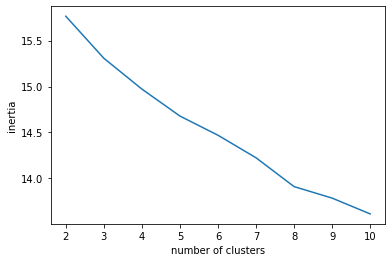

In [50]:
# define the best number of clusters
K_MAX_CLUSTERS = 11
inertia = []

for kclusters in range(2, K_MAX_CLUSTERS):
    #print(kclusters)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nycANDmosc_clustering_df)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, K_MAX_CLUSTERS), inertia)
plt.xlabel('number of clusters')
plt.ylabel('inertia')

#There is an 'elbow' on the innertia graph when k = 8. Therefore the optimal number of centroids for K-mean clustering is 8

In [51]:
#Perform clustering with 8 centroids
kmeans = KMeans(n_clusters = 8, random_state = 0).fit(nycANDmosc_clustering_df)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 3, 5, 3, 2, 6, 1, 1, 1], dtype=int32)

In [53]:
# add clustering labels
nycANDmosc_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
# nycANDmosc_grouped.head(10)

In [61]:
# now make a dafaframe with district names, cluster labels, latitudes and longitudes
moscow_merged = moscow_df

# merge manhattan_grouped with moscow_data to add latitude/longitude for each neighborhood
moscow_merged = moscow_merged.join(nycANDmosc_venues_sorted.set_index('District'), on = 'District')
moscow_merged = moscow_merged.dropna()
# add cluster label
moscow_merged['Cluster Labels'] = moscow_merged['District'].map(nycANDmosc_grouped.set_index('District')['Cluster Labels'])
    

moscow_merged.head(10)

,District,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Cluster Labels
0,Arbat,55.751199,37.589872,Coffee Shop,Restaurant,Hostel,Bar,Bakery,Turkish Restaurant,Hookah Bar,2
1,Basmanny,55.757774,37.662184,Art Gallery,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Clothing Store,Office,Boutique,2
3,Krasnoselsky,55.774248,37.659914,Cosmetics Shop,Theater,Escape Room,Fast Food Restaurant,Clothing Store,Hookah Bar,Mobile Phone Shop,2
4,Meshchansky,55.763013,37.622559,Coffee Shop,Boutique,Cocktail Bar,Hotel,Shoe Store,Plaza,Clothing Store,2
5,Presnensky,55.756276,37.605422,Theater,Cocktail Bar,Wine Bar,Coffee Shop,Park,Bakery,Concert Hall,2
6,Tagansky,55.741572,37.667063,Bar,Café,Coffee Shop,Pharmacy,Park,Restaurant,Cosmetics Shop,2
7,Tverskoy,55.762539,37.608913,Theater,Restaurant,Park,Café,Health & Beauty Service,Yoga Studio,Clothing Store,2
8,Yakimanka,55.738374,37.616913,Coffee Shop,Café,Gym / Fitness Center,Restaurant,Art Gallery,Men's Store,Vegetarian / Vegan Restaurant,2
9,Zamoskvorechye,55.729095,37.641031,Coffee Shop,Café,Mobile Phone Shop,Jewelry Store,Middle Eastern Restaurant,Seafood Restaurant,Art Gallery,2
10,Aeroport,55.800402,37.533156,Café,Coffee Shop,Cosmetics Shop,Convenience Store,Flower Shop,Caucasian Restaurant,Pet Store,2


In [62]:
#same for newyork
newyork_merged = newyork_df

newyork_merged = newyork_merged.join(nycANDmosc_venues_sorted.set_index('District'), on = 'District')
newyork_merged = newyork_merged.dropna()
# add cluster label
newyork_merged['Cluster Labels'] = newyork_merged['District'].map(nycANDmosc_grouped.set_index('District')['Cluster Labels'])

newyork_merged.head(10)

,District,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,Cluster Labels
1,Co-op City,40.874294,-73.829939,Bus Station,Accessories Store,Restaurant,Fast Food Restaurant,Donut Shop,Discount Store,Deli / Bodega,5
2,Eastchester,40.887556,-73.827806,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Bus Stop,Donut Shop,Food & Drink Shop,4
4,Riverdale,40.890834,-73.912585,Bus Station,Park,Playground,Bank,Gym,Gym / Fitness Center,Home Service,7
5,Kingsbridge,40.881687,-73.902818,Pizza Place,Sandwich Place,Bar,Bakery,Latin American Restaurant,Mexican Restaurant,Café,5
6,Marble Hill,40.876551,-73.910660,Gym,Coffee Shop,Sandwich Place,Department Store,Pizza Place,Kids Store,Ice Cream Shop,5
7,Woodlawn,40.898273,-73.867315,Pub,Deli / Bodega,Pizza Place,Playground,Food Truck,Trail,Bar,6
8,Norwood,40.877224,-73.879391,Pizza Place,Park,Chinese Restaurant,Pharmacy,Bus Station,Bank,Mobile Phone Shop,4
10,Baychester,40.866858,-73.835798,Bank,Donut Shop,Shopping Mall,Electronics Store,Spanish Restaurant,Pizza Place,Fast Food Restaurant,5
11,Pelham Parkway,40.857413,-73.854756,Pizza Place,Frozen Yogurt Shop,Italian Restaurant,Deli / Bodega,Performing Arts Venue,Bus Station,Café,1
12,City Island,40.847247,-73.786488,Seafood Restaurant,Boat or Ferry,Deli / Bodega,Thrift / Vintage Store,Cosmetics Shop,Tapas Restaurant,Baseball Field,1


Now lets visualize our clusters on the map of Moscow!

In [63]:
# create map
def draw_clusters_map(city_latitude, city_longitude, city_merged, zoom_start):
    city_map_clusters = folium.Map(location=[city_latitude, city_longitude], zoom_start = zoom_start)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['District'], city_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(city_map_clusters)
       
    return city_map_clusters

In [76]:
#Make a map of Moscow
MOSCOW_LATITUDE = 55.751244
MOSCOW_LONGITUDE = 37.618423

moscow_map = draw_clusters_map(MOSCOW_LATITUDE, MOSCOW_LONGITUDE, moscow_merged, zoom_start = 10)
moscow_map

In [77]:
#Make a map of New York
NY_LATITUDE = 40.730610
NY_LONGITUDE = -73.935242

newyork_map = draw_clusters_map(NY_LATITUDE, NY_LONGITUDE, newyork_merged, zoom_start = 11)
newyork_map

### Results

We created tables containig names and coordinates districts of Moscow and New York. Using Foursquare API, we explored venues in those districts and analyzed how common each venue is in each district. We filtered out districts having less than 10 venues, because they do not provide enough data for valid clustering. We then merged the resulting tables of venues frequences and used K-means algorythm for clustering to find groups of similar districts. We determined that the optimum number of centroids was 8. We then used Folium maps to visualize the clusters in each city.

As expected, many districts belonging to the same cluster are not randomly distributed but rather form groups on the map. This means that our clustering algorythm works.

We can see that majority of Moscow districts belong to cluster 2, with a few districts belonging to clusters 0, 1, 3 and 7.
On the other hand, New York seems to be more diverse with almost every cluster represented. Most of the central city districts belong cluster 1, with numerous districts belonging to clusters 0, 2, 4, 5, 6 and 7. Cluster 3 is unique for Moscow and clusters 4 and 6 are unique for New York.

Lets have a look at some of the Moscow districts belonging to clusters 1 (most common in New York), 2 (most common in Moscow) and 3 (unique for Moscow)

In [66]:
# Moscow, cluster 1
moscow_merged.loc[moscow_merged['Cluster Labels'] == 1, moscow_merged.columns[[0] + list(range(3, moscow_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
11,Begovoy,Health Food Store,Bar,Turkish Restaurant,Hookah Bar,Massage Studio,Irish Pub,Butcher


Interestingly, while cluster 1 covers most of the New York districts, the only district belonging to closter 1 is Begovoy 

Next, cluster 2, most common in Moscow

In [67]:
# Moscow, cluster 2
moscow_merged.loc[moscow_merged['Cluster Labels'] == 2, moscow_merged.columns[[0] + list(range(3, moscow_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Arbat,Coffee Shop,Restaurant,Hostel,Bar,Bakery,Turkish Restaurant,Hookah Bar
1,Basmanny,Art Gallery,Coffee Shop,Cosmetics Shop,Gym / Fitness Center,Clothing Store,Office,Boutique
3,Krasnoselsky,Cosmetics Shop,Theater,Escape Room,Fast Food Restaurant,Clothing Store,Hookah Bar,Mobile Phone Shop
4,Meshchansky,Coffee Shop,Boutique,Cocktail Bar,Hotel,Shoe Store,Plaza,Clothing Store
5,Presnensky,Theater,Cocktail Bar,Wine Bar,Coffee Shop,Park,Bakery,Concert Hall
...,...,...,...,...,...,...,...,...
118,Strogino,Pet Store,Sauna / Steam Room,Eastern European Restaurant,Liquor Store,Toy / Game Store,Beer Bar,Buffet
120,Matushkino,Cafeteria,Café,Electronics Store,Toy / Game Store,Indie Movie Theater,Lingerie Store,IT Services
121,Savyolki,Gym / Fitness Center,Coffee Shop,Supermarket,Hockey Arena,Concert Hall,Gym,Office
124,Kryukovo,Clothing Store,Pizza Place,Fast Food Restaurant,Electronics Store,Mobile Phone Shop,Coffee Shop,Supermarket


Now, cluster 3, unique for Moscow

In [68]:
# Moscow, cluster 3
moscow_merged.loc[moscow_merged['Cluster Labels'] == 3, moscow_merged.columns[[0] + list(range(3, moscow_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
17,Koptevo,Auto Workshop,Bus Stop,Supermarket,Convenience Store,Caucasian Restaurant,Light Rail Station,Food & Drink Shop
23,Vostochnoye Degunino,Supermarket,Auto Workshop,Pedestrian Plaza,Bus Line,Playground,Soccer Field,Pharmacy
26,Alexeyevsky,Auto Workshop,Hotel,Supermarket,Health Food Store,Gym / Fitness Center,Dance Studio,Mobile Phone Shop
27,Altufyevsky,Supermarket,Health Food Store,Dry Cleaner,Bus Stop,Salon / Barbershop,Café,Gym Pool
37,Rostokino,Light Rail Station,Food & Drink Shop,Bar,Supermarket,IT Services,Auto Workshop,Auto Dealership
59,Kapotnya,Supermarket,Concert Hall,Hotel,Playground,Deli / Bodega,Asian Restaurant,Bus Stop
76,Chertanovo Yuzhnoye,Auto Workshop,Japanese Restaurant,Wine Shop,Pizza Place,Pedestrian Plaza,Restaurant,Bus Stop
110,Troparyovo-Nikulino,Supermarket,Gym,Men's Store,Flower Shop,Bus Stop,Butcher,Café


Now, lets check districts of New York belonging to cluster 1 (most common in New York), cluster 2 (most common in Moscow) and clusters 4 and 6, (unique for New York)

In [69]:
# New York, cluster 1
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
11,Pelham Parkway,Pizza Place,Frozen Yogurt Shop,Italian Restaurant,Deli / Bodega,Performing Arts Venue,Bus Station,Café
12,City Island,Seafood Restaurant,Boat or Ferry,Deli / Bodega,Thrift / Vintage Store,Cosmetics Shop,Tapas Restaurant,Baseball Field
28,Throgs Neck,Bar,Pizza Place,Liquor Store,Deli / Bodega,Sports Bar,Mobile Phone Shop,Asian Restaurant
34,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Mexican Restaurant,Bank
36,North Riverdale,Pizza Place,Italian Restaurant,Chinese Restaurant,Bank,Social Club,Bagel Shop,Burger Joint
...,...,...,...,...,...,...,...,...
277,Sunnyside Gardens,Bar,Grocery Store,Pizza Place,Korean Restaurant,American Restaurant,Coffee Shop,Bank
280,Vinegar Hill,Food Truck,Café,Coffee Shop,Wine Shop,Wine Bar,Performing Arts Venue,Latin American Restaurant
283,Dumbo,Park,Ice Cream Shop,American Restaurant,Scenic Lookout,Bakery,Coffee Shop,Gym
290,Middle Village,South American Restaurant,Thrift / Vintage Store,Italian Restaurant,Playground,Ice Cream Shop,Park,Sushi Restaurant


In [70]:
# New York, cluster 2
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
51,Brighton Beach,Russian Restaurant,Donut Shop,Bank,Sushi Restaurant,Mobile Phone Shop,Beach,Pharmacy
112,Lincoln Square,Plaza,Performing Arts Venue,Gym / Fitness Center,Theater,Café,Concert Hall,Park
185,Hillcrest,College Academic Building,Grocery Store,College Cafeteria,College Basketball Court,Food Court,Food,Donut Shop
189,Lefrak City,Cosmetics Shop,Bakery,Supermarket,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Warehouse Store
239,Charleston,Coffee Shop,Shoe Store,Cosmetics Shop,Big Box Store,Hardware Store,Kids Store,Burger Joint
286,Sandy Ground,Bus Stop,Greek Restaurant,Fish & Chips Shop,Racetrack,Playground,Food Truck,Historic Site


Look, Brighton Beach, a Russian district of New York, belongs to the same cluster as most of the districts in Moscow! This confirms that our clusterin works! Perhaps the other five districts from cluster 2 may be interesting for Russians seeking to buy appartments in New York districts that have venues that are most similar to ones in Moscow.

Next, clusters 4 and 6, unique for New York

In [71]:
# New York, cluster 4
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
2,Eastchester,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Bus Stop,Donut Shop,Food & Drink Shop
8,Norwood,Pizza Place,Park,Chinese Restaurant,Pharmacy,Bus Station,Bank,Mobile Phone Shop
13,Bedford Park,Chinese Restaurant,Mexican Restaurant,Pizza Place,Diner,Deli / Bodega,Food Truck,Fried Chicken Joint
18,West Farms,Bus Station,Park,Gym,Basketball Court,Metro Station,Coffee Shop,Diner
19,High Bridge,Chinese Restaurant,Spanish Restaurant,Bus Station,Pizza Place,Pharmacy,Latin American Restaurant,Food
26,Soundview,Chinese Restaurant,Fried Chicken Joint,Latin American Restaurant,Liquor Store,Bus Stop,Discount Store,Bus Station
42,Pelham Gardens,Pharmacy,Bus Station,Chinese Restaurant,Pizza Place,Playground,Italian Restaurant,Spanish Restaurant
43,Concourse,Deli / Bodega,Grocery Store,Italian Restaurant,Bakery,Chinese Restaurant,Bus Station,Clothing Store
56,East Flatbush,Chinese Restaurant,Caribbean Restaurant,Supermarket,Wine Shop,Department Store,Liquor Store,Park
60,Brownsville,Fried Chicken Joint,Chinese Restaurant,Convenience Store,Farmers Market,Pizza Place,Playground,Trail


In [72]:
# New York, cluster 6
newyork_merged.loc[newyork_merged['Cluster Labels'] == 6, newyork_merged.columns[[0] + list(range(3, newyork_merged.shape[1] - 1))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
7,Woodlawn,Pub,Deli / Bodega,Pizza Place,Playground,Food Truck,Trail,Bar
32,Van Nest,Deli / Bodega,Pizza Place,Bus Station,Coffee Shop,Shop & Service,Donut Shop,Supermarket
89,Ocean Hill,Deli / Bodega,Bakery,Southern / Soul Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Grocery Store,Donut Shop
190,Belle Harbor,Beach,Boutique,Italian Restaurant,Spa,Pub,Deli / Bodega,Donut Shop
195,North Corona,Deli / Bodega,Gym / Fitness Center,Bakery,Coffee Shop,Spanish Restaurant,Food Truck,Mexican Restaurant
228,Arrochar,Italian Restaurant,Deli / Bodega,Bus Stop,Liquor Store,Pizza Place,Hotel,Sandwich Place
232,Midland Beach,Beach,Deli / Bodega,Bookstore,Liquor Store,Russian Restaurant,Martial Arts School,Bus Stop
234,New Dorp Beach,Italian Restaurant,Deli / Bodega,Women's Store,Food,Restaurant,Beach,Other Repair Shop
252,Shore Acres,Bus Stop,Italian Restaurant,Deli / Bodega,Bar,Intersection,Gastropub,Restaurant
254,Concord,Deli / Bodega,Coffee Shop,Train Station,Grocery Store,Cosmetics Shop,Bus Stop,Bagel Shop


### Discussion

We determined that there are both districts that are similar between New York and Moscow, and districts that are unique for each city. Moscow districts are slightly more uniform, while New York is much more diverse, which is probably because of the high cultural diversity and ethnic segregation of the population. New York has Italian, Chinese, Latin districts, which obviously influence their most common venue types.

We found that Brighton Beach, a Russian district in New York, indeed belongs to a cluster that covers most of Moscow, proving that our clustering approach was valid. We also found several more districts in New York belonging to the same cluster, which may be insteresting to Russians seeking for appartments, as well as real estate agents working with Russian speaking customers.